# Performing Neural Style Transfer with Captum.optim

In this tutorial we'll learn how to perform the standard [neural style transfer](https://en.wikipedia.org/wiki/Neural_Style_Transfer) (NST) algorithm with Captum. NST algorithms attempt to recreate a given input image in the style of one or more style images.

You can also check out the [neural style transfer tutorial](https://pytorch.org/tutorials/advanced/neural_style_tutorial.html) from PyTorch Tutorials for a more simplistic overview of neural style transfer.


In [2]:
%load_ext autoreload
%autoreload 2

import math
from typing import Optional, Callable, List, Tuple, Dict, Union, Type
from warnings import warn

import captum.optim as opt
import torch
import torch.nn.functional as F
import torchvision
from captum.optim.models import googlenet


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

LossFunction = Callable[[Dict[torch.nn.Module, Optional[torch.Tensor]]], torch.Tensor]
ModuleOutputMapping = Dict[torch.nn.Module, Optional[torch.Tensor]]

## Setup

For convenience, we can create two helper functions to handle image resizing and color matching. We'll also create a helper function to help compare our input images to the stylized output image.

In [3]:
def resize_image(
    image: Union[torch.Tensor, List[torch.Tensor]],
    size: Union[int, Tuple[int, int], List[int]] = 512,
    scale: float = 1.0,
) -> Union[torch.Tensor, List[torch.Tensor]]:
    """
    Resize images based on a maximum side length or specific height and width, while
    preserving the ratio. As neural style transfer can be extremely GPU intensive,
    this sort of resizing is more effective than torchvision.transforms.Resize, which
    resizes images based on the smaller dimension.

    Args:

        image (torch.Tensor or list of torch.Tensor): One or more image tensors
            to resize.
        size (int or list of int, optional): The maximum side length or a specific
            height and width to use.
            Default: 512
        scale (float, optional): Scale the output size by a given value. This is useful
            for manipulating style image feature size.
            Default: 1.0

    Returns:
        image (torch.Tensor or list of torch.Tensor): One or more resized images.
    """

    def resize(
        im: torch.Tensor, s: Union[int, Tuple[int, int], List[int]], scale: float
    ) -> torch.Tensor:
        im = im.unsqueeze(0) if im.dim() == 3 else im
        assert im.dim() == 4
        if not hasattr(s, "__iter__"):
            s = [
                int((float(s) / max(im.shape[2:]) * i))
                for i in (im.shape[2], im.shape[3])
            ]
        assert len(s) == 2
        s = [int(i * scale) for i in s]
        return F.interpolate(im.clone(), size=s, mode="bilinear", align_corners=False)

    if torch.is_tensor(image):
        return resize(image, size, scale)

    else:
        return [resize(im, size, scale) for im in image]


def show_input_images(
    content_image: torch.Tensor,
    style_image: Union[torch.Tensor, List[torch.Tensor]],
    figsize: Optional[Tuple[int, int]] = None,
    scale: float = 255.0,
) -> None:
    """
    Display content and style images side by side while preserving aspect ratio.

    Args:

        content_image (torch.Tensor): The content image.
        style_image (torch.Tensor or list of torch.Tensor): One or more style image
            tensors.
        figsize (Tuple[int, int], optional): height & width to use for displaying the
            image figure.
            Default: None
        scale (float): Value to multiply the input tensor by so that it's value range
            is [0-255] for display.
            Default: 255.0
    """
    if content_image.dim() == 3:
        content_image = content_image.unsqueeze(0)
    assert content_image.dim() == 4
    H = content_image.size(2)
    style_image = [style_image] if torch.is_tensor(style_image) else style_image
    A: List[torch.Tensor] = []
    for s in style_image:
        s = s.unsqueeze(0) if s.dim() == 3 else s
        assert s.dim() == 4
        sH, sW = s.shape[2:]
        nW = int(sW / (sH / H))
        A.append(resize_image(s, size=(H, nW)).to(content_image.device))
    img = torch.cat([content_image] + A, dim=3)
    opt.images.show(img, figsize=figsize, scale=scale)


def color_transfer(
    input: torch.Tensor,
    source: torch.Tensor,
    mode: str = "pca",
    eps: float = 1e-5,
) -> torch.Tensor:
    """
    Transfer the colors from one image tensor to another, so that the target image's
    histogram matches the source image's histogram. Applications for image histogram
    matching includes neural style transfer and astronomy.

    The source image is not required to have the same height and width as the target
    image. Batch and channel dimensions are required to be the same for both inputs.

    Gatys, et al., "Controlling Perceptual Factors in Neural Style Transfer", arXiv, 2017.
    https://arxiv.org/abs/1611.07865

    Args:

        input (torch.Tensor): The NCHW or CHW image to transfer colors from source
            image to from the source image.
        source (torch.Tensor): The NCHW or CHW image to transfer colors from to the
            input image.
        mode (str): The color transfer mode to use. One of 'pca', 'cholesky', or 'sym'.
            Default: "pca"
        eps (float): The desired epsilon value to use.
            Default: 1e-5

    Returns:
        matched_image (torch.tensor): The NCHW input image with the colors of source
            image. Outputs should ideally be clamped to the desired value range to
            avoid artifacts.
    """

    assert input.dim() == 3 or input.dim() == 4
    assert source.dim() == 3 or source.dim() == 4
    input = input.unsqueeze(0) if input.dim() == 3 else input
    source = source.unsqueeze(0) if source.dim() == 3 else source
    assert input.shape[:2] == source.shape[:2]

    # Handle older versions of PyTorch
    torch_cholesky = (
        torch.linalg.cholesky if torch.__version__ >= "1.9.0" else torch.cholesky
    )

    def torch_symeig_eigh(x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        torch.symeig() was deprecated in favor of torch.linalg.eigh()
        """
        if torch.__version__ >= "1.9.0":
            L, V = torch.linalg.eigh(x, UPLO="U")
        else:
            L, V = torch.symeig(x, eigenvectors=True, upper=True)
        return L, V

    def get_mean_vec_and_cov(
        x_input: torch.Tensor, eps: float
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Convert input images into a vector, subtract the mean, and calculate the
        covariance matrix of colors.
        """
        x_mean = x_input.mean(3).mean(2)[:, :, None, None]

        # Subtract the color mean and convert to a vector
        B, C = x_input.shape[:2]
        x_vec = (x_input - x_mean).reshape(B, C, -1)

        # Calculate covariance matrix
        x_cov = torch.bmm(x_vec, x_vec.permute(0, 2, 1)) / x_vec.shape[2]

        # This line is only important if you get artifacts in the output image
        x_cov = x_cov + (eps * torch.eye(C, device=x_input.device)[None, :])
        return x_mean, x_vec, x_cov

    def pca(x: torch.Tensor) -> torch.Tensor:
        """Perform principal component analysis"""
        eigenvalues, eigenvectors = torch_symeig_eigh(x)
        e = torch.sqrt(torch.diag_embed(eigenvalues.reshape(eigenvalues.size(0), -1)))
        # Remove any NaN values if they occur
        if torch.isnan(e).any():
            e = torch.where(torch.isnan(e), torch.zeros_like(e), e)
        return torch.bmm(torch.bmm(eigenvectors, e), eigenvectors.permute(0, 2, 1))

    # Collect & calculate required values
    _, input_vec, input_cov = get_mean_vec_and_cov(input, eps)
    source_mean, _, source_cov = get_mean_vec_and_cov(source, eps)

    # Calculate new cov matrix for input
    if mode == "pca":
        new_cov = torch.bmm(pca(source_cov), torch.inverse(pca(input_cov)))
    elif mode == "cholesky":
        new_cov = torch.bmm(
            torch_cholesky(source_cov), torch.inverse(torch_cholesky(input_cov))
        )
    elif mode == "sym":
        p = pca(input_cov)
        pca_out = pca(torch.bmm(torch.bmm(p, source_cov), p))
        new_cov = torch.bmm(torch.bmm(torch.inverse(p), pca_out), torch.inverse(p))
    else:
        raise ValueError(
            "mode has to be one of 'pca', 'cholesky', or 'sym'."
            + " Received '{}'.".format(mode)
        )

    # Multiply input vector by new cov matrix
    new_vec = torch.bmm(new_cov, input_vec)

    # Reshape output vector back to input's shape &
    # add the source mean to our output vector
    return new_vec.reshape(input.shape) + source_mean

### Input Images

#### Content Image

The content image is the image that we wish to recreate in the artistic style of our chosen style image or style images.

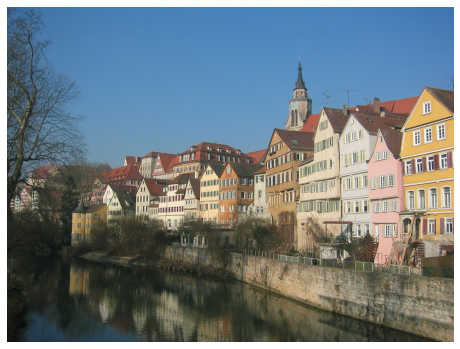

In [4]:
content_path = "https://github.com/ProGamerGov/neural-style-pt/raw/master/examples/inputs/tubingen.jpg"
content_image_full = opt.ImageTensor.open(content_path).unsqueeze(0)
content_image_full.show(figsize=(8, 8))

#### Style Image

We choose one or more style images that contain the desired artistic style that we want to transfer to the content image. For this tutorial, we'll use [The Starry Night](https://en.wikipedia.org/wiki/The_Starry_Night) painted by 	Vincent van Gogh.

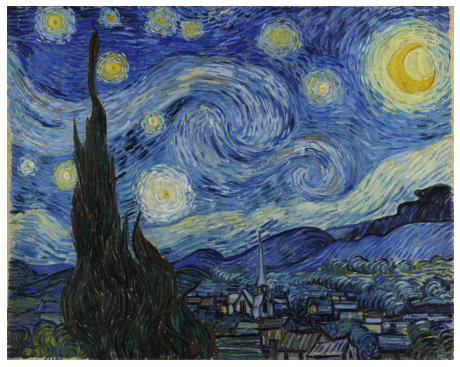

In [5]:
style_path = (
    "https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/" 
    + "Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/"
    + "2728px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg"
)

style_image_full = opt.ImageTensor.open(style_path).unsqueeze(0)
style_image_full.show(figsize=(8, 8))

#### Preprocessing The Content Image

We can help the optimization process by preprocessing our content image so that it's colors match the colors found in the style image.

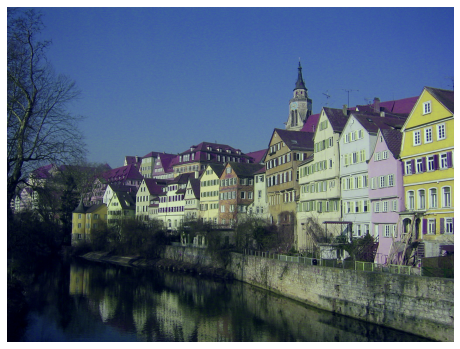

In [6]:
content_image_matched = color_transfer(content_image_full, style_image_full).clamp(0, 1)
content_image_matched.show(figsize=(8, 8))

### Criterion

For the InceptionV1 model, the Lucid library utilizes a mean l1 loss criterion to compare the model activations with the target activations. Thus, we'll use the same criterion for our InceptionV1 neural style transfer experiments. For VGG models, the recommended criterion is MSE Loss and thus we'll use [`torch.nn.functional.mse_loss`](https://pytorch.org/docs/stable/nn.functional.html#mse-loss) for them.

In [7]:
def mean_l1(x: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    """
    Mean L1 loss criterion for use with neural style transfer.

    Args:

        x (torch.Tensor): A tensor to use for comparison to the target.
        target (torch.Tensor): The tensor to compare x to.

    Returns:
        tensor (torch.Tensor): A scalar loss value.
    """
    return torch.mean(torch.abs(x - target))

### Content and Style Objectives

We set two main objective types for the image being optimized to work towards; `ContentLoss` and `StyleLoss`. 

The content objective encourages similarity to the content image by attempting to minimize the distance from the image being optimized to the content image, at the target layer. The style objective works almost exactly the same, except that we first calculate a normalized [gram matrix](https://en.wikipedia.org/wiki/Gram_matrix) before the criterion based comparison.

In [8]:
@opt.loss.loss_wrapper
class ContentLoss(opt.loss.BaseLoss):
    """
    Calculate the distance to the target activations.
    """

    def __init__(
        self,
        target: torch.nn.Module,
        target_activations: Optional[torch.Tensor],
        criterion: Callable[[torch.Tensor], torch.Tensor] = F.mse_loss,
        batch_index: Optional[int] = None,
    ) -> None:
        """
        Args:

            target (nn.Module): The desired layer target to use.
            target_activations (torch.Tensor, optional): Layer activations to
                calculate the distance to. If set to None, then content image
                activations are collected in the forward pass.
            criterion (Callable, optional): The desired criterion to use for
                calculating the distance to the target activations.
                Default: torch.nn.functional.mse_loss
            batch_index (int, optional): The target batch index to use.
                Default: None
        """
        opt.loss.BaseLoss.__init__(self, target, batch_index)
        self.target_activations = target_activations
        self.criterion = criterion

    def __call__(self, targets_to_values: ModuleOutputMapping) -> torch.Tensor:
        activations = targets_to_values[self.target]
        if self.target_activations is None:
            assert activations.shape[0] == 3
            target_activations = activations[1:2].clone()
            activations = activations[0:1].clone()
        else:
            target_activations = self.target_activations
            activations = activations[self.batch_index[0] : self.batch_index[1]]

        # Calculate distance to target activations
        return self.criterion(activations, target_activations)


def gram_matrix(x: torch.Tensor) -> torch.Tensor:
    """
    Calculate a normalized gram matrix for a given input tensor.

    Args:
        x (torch.Tensor): A tensor to calculate the normalized gram matrix for. Inputs
            are required to have a batch dimension, and one or more additional dimensions.

    Returns:
        tensor (torch.Tensor): The normalized gram matrix of x.
    """
    assert x.dim() > 1
    B, C = x.shape[:2]
    # Reshape into desired matrix
    x_flat = x.view(B, C, -1)
    # Multiply matrix by transposed matrix & normalize by the number of input elements
    return torch.bmm(x_flat, x_flat.permute(0, 2, 1)) / x.nelement()


@opt.loss.loss_wrapper
class StyleLoss(opt.loss.BaseLoss):
    """
    Calculate the distance to the target activations using a normalized gram matrix.
    """

    def __init__(
        self,
        target: torch.nn.Module,
        target_activations: Optional[torch.Tensor],
        criterion: Callable[[torch.Tensor], torch.Tensor] = F.mse_loss,
        batch_index: Optional[int] = None,
    ) -> None:
        """
        Args:

            target (nn.Module): The desired layer target to use.
            target_activations (torch.Tensor, optional): Layer activations to
                calculate the distance to. If set to None, then style image
                activations are collected in the forward pass.
            criterion (Callable, optional): The desired criterion to use for
                calculating the distance to the target activations.
                Default: torch.nn.functional.mse_loss
            batch_index (int, optional): The target batch index to use.
                Default: None
        """
        opt.loss.BaseLoss.__init__(self, target, batch_index)
        if target_activations is not None:
            target_activations = gram_matrix(target_activations)
        self.target_activations = target_activations
        self.criterion = criterion

    def __call__(self, targets_to_values: ModuleOutputMapping) -> torch.Tensor:
        activations = targets_to_values[self.target]
        if self.target_activations is None:
            assert activations.shape[0] == 3
            target_activations = gram_matrix(activations[2:3].clone())
            activations = activations[0:1].clone()
        else:
            target_activations = self.target_activations
            activations = activations[self.batch_index[0] : self.batch_index[1]]
        grams = gram_matrix(activations)
        # Calculate distance to target activations
        return self.criterion(grams, target_activations)

#### Objective Setup

Neural style transfer utilizes multiple content and style objectives for different layers of the model being used. Each content and style objective requires a target to optimize towards in the form of captured activations from the corresponding image. Below we define a helper function to set up content and style objectives with the required activation targets.

In [9]:
def create_obj(
    obj: Type[LossFunction],
    model: torch.nn.Module,
    image: Optional[torch.Tensor],
    targets: List[torch.nn.Module],
    crit_fn: Callable[[torch.Tensor], torch.Tensor] = F.mse_loss,
    batch_index: Optional[int] = None,
) -> List[LossFunction]:
    """
    Capture activations and set loss targets.

    Args:

        obj: A loss function that inherits from Captum's BaseLoss class, to place
            activation targets on.
        model (nn.Module): A PyTorch model instance.
        image (torch.Tensor, optional): The NCHW image tensor to collect and use
            activations from.
        targets (list of nn.Module): List of target layers to use.
        crit_fn (Callable, optional): The desired criterion to use for calculating the
            distance to the target activations.
            Default: torch.nn.functional.mse_loss
        batch_index (int, optional): The target batch index to use.
            Default: None
    """
    if image is not None:
        assert image.dim() == 3 or image.dim() == 4
        targets_dict = opt.models.collect_activations(model, targets, image.clone())

    obj_list: List[LossFunction] = []
    for t in targets:
        target_activ = None if image is None else targets_dict[t].detach()
        obj_list.append(
            obj(
                t,
                target_activations=target_activ,
                criterion=crit_fn,
                batch_index=batch_index,
            )
        )
    return obj_list

## Style transfer with InceptionV1

Using the Optim submodule, we can make it possible to perform neural style transfer with the default Inception V1 model from Caffe.

Like in the corresponding [Lucid paper](https://distill.pub/2018/differentiable-parameterizations/#section-styletransfer), we will utilize image parameterization and transforms to accomplish neural style transfer.

In [ ]:
inceptionv1_model = (
    googlenet(pretrained=True, replace_relus_with_redirectedrelu=False)
    .to(device)
    .eval()
)

In [11]:
def sigmoid_image(x: torch.Tensor) -> torch.Tensor:
    return torch.cat([torch.sigmoid(x[0:1]), x[1:]], 0)


class Recorrelate(torch.nn.Module):
    def __init__(self, fn: Callable) -> None:
        super().__init__()
        self.fn = fn

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.cat([self.fn(x[0:1]), x[1:]], 0)


def vis_style_transfer_inception(
    model: torch.nn.Module,
    content_image: torch.Tensor,
    style_image: torch.Tensor,
    content_layers: List[torch.nn.Module],
    style_layers: List[torch.nn.Module],
    content_weight: float = 1.0,
    style_weight: float = 10.0,
    init_image: Optional[torch.Tensor] = None,
    transforms: Optional[torch.nn.Module] = torch.nn.Identity(),
    num_steps: int = 256,
    decorrelate: bool = True,
) -> torch.Tensor:
    # Initialize with content image if no initialization image is specified
    init_image = init_image if init_image is not None else content_image.clone()

    # Setup image being optimized
    if decorrelate:
        decorrelation_module = opt.transforms.ToRGB(transform="klt")
        init_image = decorrelation_module(init_image, inverse=True)
        parameterization = opt.images.FFTImage(init=init_image)
        squash_func = sigmoid_image
        decorrelation_module = Recorrelate(decorrelation_module)

    else:
        parameterization = opt.images.PixelImage(init=init_image)
        squash_func = lambda x: x
        decorrelation_module = None

    parameterization = opt.images.StackImage(
        [parameterization, content_image, style_image]
    )

    image = opt.images.NaturalImage(
        parameterization=parameterization,
        squash_func=squash_func,
        decorrelation_module=decorrelation_module,
    ).to(device)

    # Create our content objective
    content_loss_fn = create_obj(ContentLoss, model, None, content_layers, mean_l1)
    content_obj = sum([c * content_weight for c in content_loss_fn])

    # Create style objective
    style_loss_fn = create_obj(StyleLoss, model, None, style_layers, mean_l1)
    style_obj = sum([s * style_weight for s in style_loss_fn])

    # Merge content and style objectives together
    loss_fn = content_obj + style_obj

    # Render the output
    obj = opt.InputOptimization(model, loss_fn, image, transforms)
    history = obj.optimize(
        opt.optimization.n_steps(num_steps, True), loss_summarize_fn=torch.sum
    )
    return image().cpu().detach()

### Without Decorrelation, Transform Robustness, or Color Matching

By default the InceptionV1 model performs poorly on stylization tasks, as we can see below. Without the use of Captum's `FFTImage` parameterization, color decorrelation, and color matching, the optimization process has a great deal of difficulty rendering anything.

  0%|          | 0/256 [00:00<?, ? step/s]

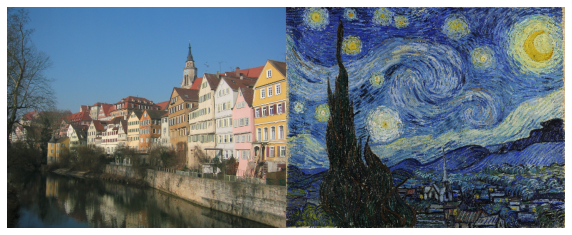

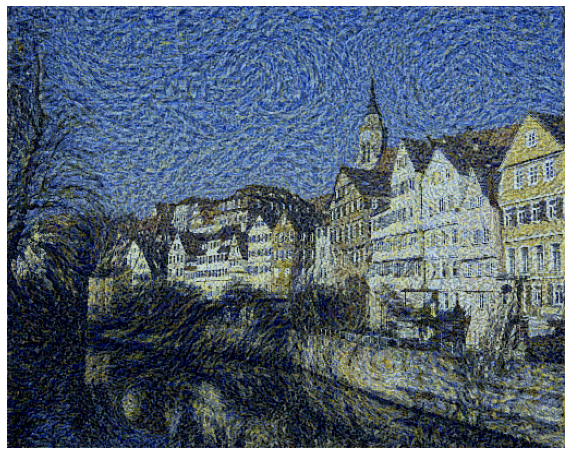

In [16]:
# Set content and style targets
content_layers = [inceptionv1_model.mixed3b_relu]
style_layers = [
    inceptionv1_model.conv3_relu,
    inceptionv1_model.mixed3a_relu,
    inceptionv1_model.mixed4a_relu,
    inceptionv1_model.mixed4b_relu,
    inceptionv1_model.mixed4c_relu,
]

# Set content and style weights
content_weight = 0.05
style_weight = 100

# Set input images
image_size = [405, 512]
# Use color matched content_image
content_image = resize_image(content_image_full, image_size).to(device)
style_image = resize_image(style_image_full, image_size).to(device)

# Perform neural style transfer without decorrelation and transform robustness
output_image = vis_style_transfer_inception(
    model=inceptionv1_model,
    content_image=content_image,
    style_image=style_image,
    content_layers=content_layers,
    style_layers=style_layers,
    content_weight=content_weight,
    style_weight=style_weight,
    transforms=torch.nn.Identity(), # Use nn.Identity as a placeholder for no transforms
    decorrelate=False, # Don't use spatial or color decorrelation
).clamp(0, 1)[0:1]

# Adjust the colors of the output image
output_image = color_transfer(output_image, style_image_full).clamp(0, 1)

# Show inputs & results
show_input_images(content_image, style_image, figsize=(10, 10))
opt.images.show(output_image, figsize=(10, 10))

### With Decorrelation, Transform Robustness, & Color Matching

We can attribute some of the difficulty in stylizing the image above to the optimization process, and thus that opens the door to improving our results without changing the model!

If we combine both spatial and color decorrelation with random spatial translations and color matching, then we can get okay looking results. Obviously these results are nowhere near as good as what one could achieve with a different model, but they prove that the InceptionV1 model is a lot better at style transfer than it's given credit for.

  0%|          | 0/256 [00:00<?, ? step/s]

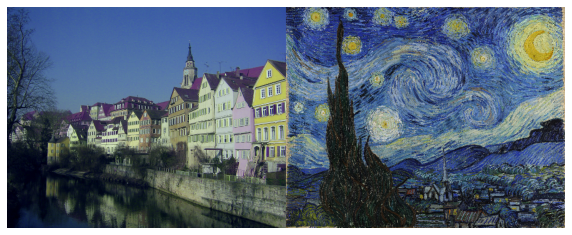

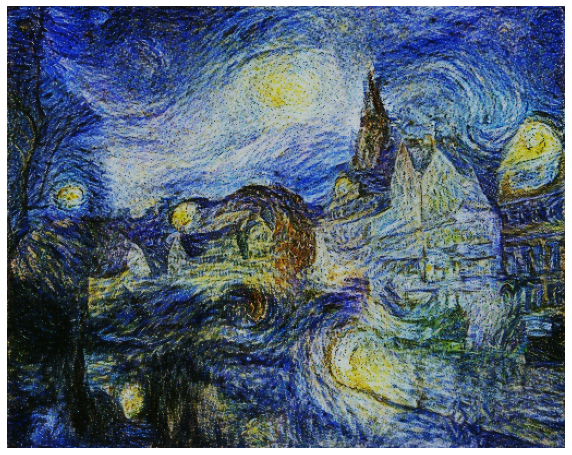

In [17]:
# Set content and style targets
content_layers = [inceptionv1_model.mixed3b_relu]
style_layers = [
    inceptionv1_model.conv3_relu,
    inceptionv1_model.mixed3a_relu,
    inceptionv1_model.mixed4a_relu,
    inceptionv1_model.mixed4b_relu,
    inceptionv1_model.mixed4c_relu,
]

# Set content and style weights
content_weight = 2.0
style_weight = 25

# Set input images
image_size = [405, 512]
# Use color matched content_image
content_image = resize_image(content_image_matched, image_size).to(device)
style_image = resize_image(style_image_full, image_size).to(device)

# Perform neural style transfer with transform robustness
output_image = vis_style_transfer_inception(
    model=inceptionv1_model,
    content_image=content_image,
    style_image=style_image,
    content_layers=content_layers,
    style_layers=style_layers,
    content_weight=content_weight,
    style_weight=style_weight,
    transforms=opt.transforms.RandomSpatialJitter(8),
    decorrelate=True,
).clamp(0, 1)[0:1]

# Adjust the colors of the output image
output_image = color_transfer(output_image, style_image_full).clamp(0, 1)

# Show inputs & results
show_input_images(content_image, style_image, figsize=(10, 10))
opt.images.show(output_image, figsize=(10, 10))

## Style transfer with VGG models

In the original neural style transfer [research paper](https://arxiv.org/abs/1508.06576), the authors found that VGG model architecture was extremely good at performing neural style transfer. In the time since then, VGG models have continued to dominate despite becoming outdated in their classification abilities. VGG models are made up of two parts, a feature model and a classification model. For the purpose of neural style transfer we only require the feature model.

While the authors used a VGG-19 model, the corresponding VGG-16 model architecture has been found to produce comparable results while utilizing less computation resources. Therefore we'll use the original VGG-16 that was trained alongside the VGG-19 model that the authors used.

Below we’ll see how to use our VGG-16 model to create amazing works of art with Captum!


In [ ]:
# Load model file
vgg16_url = (
    "https://pytorch-tutorial-assets.s3.amazonaws.com/captum/vgg16_caffe_features.pth"
)

vgg16_model = torchvision.models.vgg16(num_classes=1000)
vgg16_model.load_state_dict(
    torch.hub.load_state_dict_from_url(vgg16_url, progress=True, check_hash=False),
    strict=False,
)
vgg16_model.classifier = torch.nn.Identity()
vgg16_model = vgg16_model.to(device).eval()

image_scale = 255  # Required image scale for our VGG-16 Model
export_scale = 1


class TransformVGG(torch.nn.Module):
    __constants__ = ["scale_input"]

    def __init__(
        self,
        scale_input: bool = False,
    ) -> None:
        super().__init__()
        self.scale_input = scale_input

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        assert x.dim() == 3 or x.dim() == 4
        if self.scale_input and x.min() < 0.0 or self.scale_input and x.max() > 1.0:
            warn("Model input has values outside of the range [0, 1].")
        x = x.unsqueeze(0) if x.dim() == 3 else x
        x = x * 255 if self.scale_input else x
        x = x - torch.tensor([123.68, 116.779, 103.939], device=x.device).view(3, 1, 1)
        x = x[:, [2, 1, 0]]  # RGB to BGR
        return x

### Setup

The optim submodule is set up by default to optimize inputs with the Adam optimizer or any other optimizer one might want to use. However, optimizers like [L-BFGS](https://pytorch.org/docs/stable/optim.html#torch.optim.LBFGS) require [a slightly different structure for their optimization loop](https://pytorch.org/docs/stable/optim.html#taking-an-optimization-step), and thus we can define a custom optimization function for our `InputOptimization` instance. 

L-BFGS is the recommended choice for neural style transfer by the authors of the original paper as it produces higher quality renderings than the Adam optimizer. Thus, we’ll use it in this tutorial.

In [11]:
def optimize_with_closure(
    obj: opt.InputOptimization,
    stop_criteria: Optional[Callable] = None,
    optimizer: Optional[torch.optim.Optimizer] = None,
    loss_summarize_fn: Optional[Callable] = None,
    lr: float = 1.0,
) -> torch.Tensor:
    r"""Optimize input based on loss function and objectives.

    Args:
        obj (opt.InputOptimization): An instance of opt.InputOptimization to perform
            optimization with.
        stop_criteria (StopCriteria, optional):  A function that is called every
            iteration and returns a bool that determines whether to stop the
            optimization. See captum.optim.typing.StopCriteria for details. If set to
            None, the  n_steps stop_criteria will be used.
            Default: None
        optimizer (Optimizer, optional): A torch.optim.Optimizer instance to use for
            optimizing the input based on the loss function. If set to None, the
            torch.optim.LBFGS optimizer will be used.
            Default: None
        loss_summarize_fn (Callable, optional): The function to use for summarizing
            tensor outputs from loss functions. If set to None,
            opt.optimization.default_loss_summarize will be used.
            Default: None
        lr: (float, optional): If no optimizer is given, then lr is used as the
                learning rate for the LBFGS optimizer. If optimizer is not set to None,
                then this parameter will do nothing regardless of what it is set to.
                Default: 1.0

    Returns:
        history (torch.Tensor): A stack of loss values per iteration. The size
            of the dimension on which loss values are stacked corresponds to
            the number of iterations.
    """
    stop_criteria = stop_criteria or opt.optimization.n_steps(512)
    optimizer = optimizer or torch.optim.LBFGS(
        obj.parameters(), max_iter=1, tolerance_change=-1, tolerance_grad=-1, lr=lr
    )
    assert isinstance(optimizer, torch.optim.Optimizer)
    loss_summarize_fn = loss_summarize_fn or torch.sum

    history: List[torch.Tensor] = []

    # Use a list so that step is accessible inside closure()
    step = [0]
    try:
        while stop_criteria(step[0], obj, history, optimizer):

            def closure() -> torch.Tensor:
                optimizer.zero_grad()
                loss_value = loss_summarize_fn(obj.loss())
                history.append(loss_value.clone().detach())
                loss_value.backward()
                step[0] += 1
                return loss_value

            optimizer.step(closure)
    finally:
        obj.cleanup()
    return torch.stack(history)

### Rendering

For our vanilla style transfer using the VGG-16 model, we’ll avoid using spatial and color decorrelation as it seems to result in ugly artifacts. Transform robustness is also not required for VGG models to get good visualization results, and thus we can omit the use of transforms as well.

In [6]:
def vis_style_transfer_vgg(
    model: torch.nn.Module,
    content_image: torch.Tensor,
    style_image: Union[torch.Tensor, List[torch.Tensor]],
    content_layers: List[torch.nn.Module],
    style_layers: List[torch.nn.Module],
    content_weight: float = 1.0,
    style_weight: float = 10.0,
    init_image: Optional[torch.Tensor] = None,
    num_steps: int = 256,
    tv_weight: float = 0.0,
    lr: float = 1.0,
    transforms: Optional[torch.nn.Module] = None,
    use_lbfgs: bool = True,
    style_blend_weights: Optional[List[int]] = None,
    image_preprocessing_transform: Optional[Callable] = TransformVGG(),
) -> torch.Tensor:
    # Initialize with content image if no initialization image is specified
    init_image = init_image if init_image is not None else content_image.clone()

    # Setup image being optimized
    image = opt.images.NaturalImage(
        parameterization=opt.images.PixelImage,
        init=init_image,
        decorrelation_module=None,
        squash_func=lambda x: x,
    ).to(device)

    # Use no transforms unless the user specifies them
    transforms = torch.nn.Identity() if transforms is None else transforms

    image_preprocessing_transform = (
        torch.nn.Identity()
        if image_preprocessing_transform is None
        else image_preprocessing_transform
    )

    # Create our content objective
    content_loss_fn = create_obj(
        ContentLoss,
        model,
        image_preprocessing_transform(content_image),
        content_layers,
        F.mse_loss,
    )
    content_obj = sum([c * content_weight for c in content_loss_fn])

    # Create style objective
    def make_style_obj(s_image: torch.Tensor) -> LossFunction:
        style_loss_fn = create_obj(
            StyleLoss,
            model,
            image_preprocessing_transform(s_image),
            style_layers,
            F.mse_loss,
        )
        return sum([s * style_weight for s in style_loss_fn])

    # Handle multiple style images with optional weighting
    if torch.is_tensor(style_image):
        style_obj = make_style_obj(style_image)
    else:
        style_obj = [make_style_obj(s) for s in style_image]
        if style_blend_weights is not None:
            assert len(style_blend_weights) == len(style_image)
            style_obj = [s * w for s, w in zip(style_obj, style_blend_weights)]
        style_obj = sum(style_obj) / len(style_image)

    # Merge content and style objectives together
    loss_fn = content_obj + style_obj

    # Optionally add a total variation denoising objective
    if tv_weight > 0.0:
        loss_fn = loss_fn + (opt.loss.TotalVariation(image) * tv_weight)

    # Render the output
    obj = opt.InputOptimization(model, loss_fn, image, transforms)
    if use_lbfgs:
        # Use L-BFGS optimizer with our custom optimize function
        history = optimize_with_closure(
            obj,
            opt.optimization.n_steps(num_steps, True),
            loss_summarize_fn=torch.sum,  # Loss should be positive sum
            lr=lr,
        )
    else:
        # Use Adam optimizer
        history = obj.optimize(
            opt.optimization.n_steps(num_steps, True),
            loss_summarize_fn=torch.sum,  # Loss should be positive sum
            lr=lr,  # Use higher learning rate as image value range is [0, 255]
        )
    return image().cpu().detach()

### Basic Style Transfer

Below we perform basic style transfer with our input images using the VGG-16 model. 

**Image Scale**

Keeping the input image scale range between `[0, 255]` instead of the default `[0, 1]` seems to make choosing optimization parameters easier when working with L-BFGS. This may be related to how the default Torchvision VGG models seem to perform worse on neural style transfer tasks than the original Caffe models. Therefore, we'll multiply our input images by `255`.

The optimization process will keep most of the values within the range of `[0, 255]`, but sometimes we may end up with pixels outside of that range. A simple clamping operation after rendering has completed resolves this issue without interfering with the stylization process.

**Rendering**

Below we provide multiple parameters to help control the rendering process.

  0%|          | 0/512 [00:00<?, ? step/s]

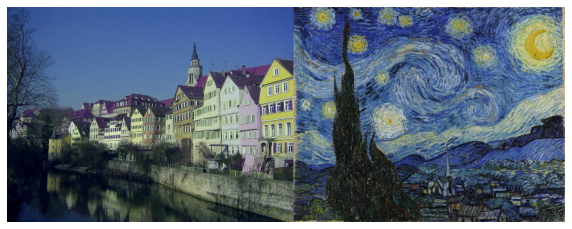

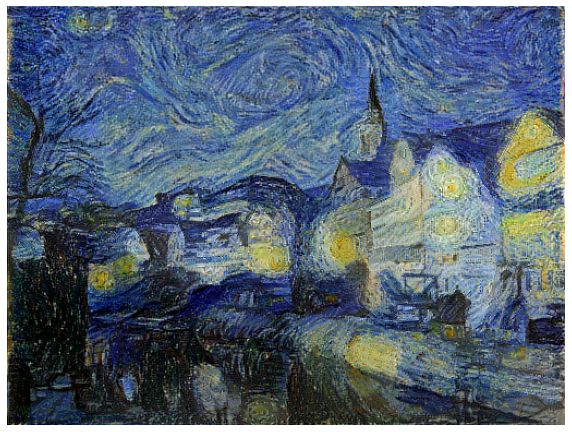

In [31]:
# Set content and style targets
content_layers = [vgg16_model.features[20]]
style_layers = [
    vgg16_model.features[1],
    vgg16_model.features[6],
    vgg16_model.features[11],
    vgg16_model.features[18],
    vgg16_model.features[25],
]

# Set content and style weights
content_weight = 0.05
style_weight = 1000.0

# Optional total variance denoising
# This can reduce artifacts at the cost of lower sharpness
tv_weight = 0.0

# Optionally set the scale of style image features
style_scale = 1.0

# Setup input images & scale to [0, 255]
image_size = 512
content_image = resize_image(content_image_matched, image_size).to(device) * image_scale
style_image = (
    resize_image(style_image_full, image_size, style_scale).to(device) * image_scale
)

init_image = None
# Uncomment to initialize from random noise
# init_image = torch.randn_like(content_image) * 0.001

# The number of rendering steps to use
num_steps = 512

# Perform neural style transfer
output_step_1 = vis_style_transfer_vgg(
    model=vgg16_model,
    content_image=content_image,
    style_image=style_image,
    content_layers=content_layers,
    style_layers=style_layers,
    content_weight=content_weight,
    style_weight=style_weight,
    init_image=init_image,
    num_steps=num_steps,
    tv_weight=tv_weight,
    transforms=TransformVGG(),
).clamp(
    0, image_scale
)  # Clamp output to avoid artifacts

# Show inputs & results
show_input_images(content_image, style_image, figsize=(10, 10), scale=export_scale)
opt.images.show(output_step_1, figsize=(10, 10), scale=export_scale)

### Multiscale Rendering

As the receptive fields in our VGG-16 model have a fixed size, the stylization process is heavily influenced by the size of the input images. This means that in order to have large scale style features in a high resolution output image, we must first render the output at a lower image size. This technique is known as multiscale rendering and it works by rendering the large scale details at the small image sizes, followed by continuing to optimize increasingly smaller image details at increasingly larger image sizes. See [here](https://arxiv.org/abs/1611.07865) for more details on multiscale generation.


As we already defined some of our parameters in the previous step, we don't have to redefine them in this step.

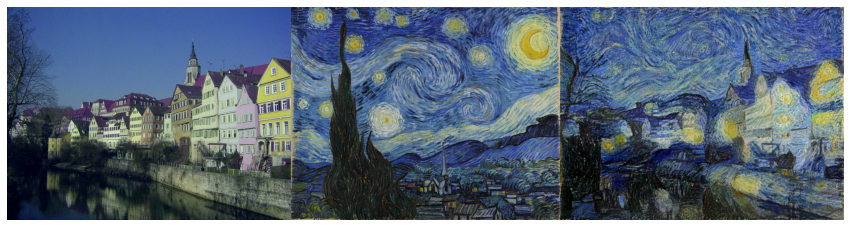

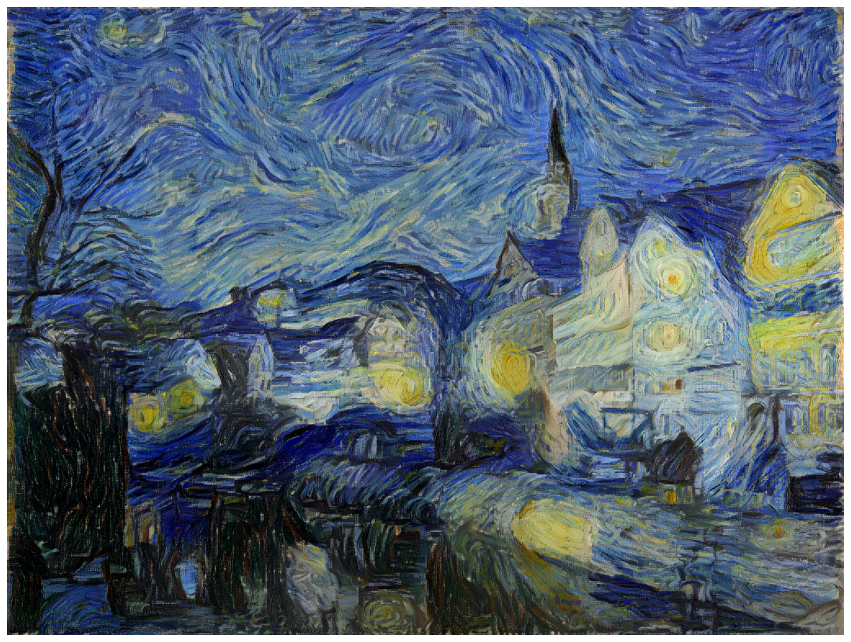

In [ ]:
# Setup input images & scale to [0, 255]
image_size = 1280
content_image = resize_image(content_image_matched, image_size).to(device) * image_scale
style_image = (
    resize_image(style_image_full, image_size, style_scale).to(device) * image_scale
)

# initialize with the output image from the previous step
s = list(content_image.shape[2:])
init_image = resize_image(output_step_1, s).to(device)

# Optionally match style image colors
init_image = color_transfer(init_image, style_image).clamp(0, image_scale)

# Perform neural style transfer
output_step_2 = vis_style_transfer_vgg(
    model=vgg16_model,
    content_image=content_image,
    style_image=style_image,
    content_layers=content_layers,
    style_layers=style_layers,
    content_weight=content_weight,
    style_weight=style_weight,
    init_image=init_image,
    num_steps=200,  # Fewer steps are needed this time around
    use_lbfgs=True,  # Set to False to lower memory if needed
    transforms=TransformVGG(),
).clamp(0, image_scale)

# Show inputs & results
show_input_images(
    content_image, [style_image, output_step_1], figsize=(15, 15), scale=export_scale
)
opt.images.show(output_step_2, figsize=(15, 15), scale=1)

# Save output image
opt.images.save_tensor_as_image(
    output_step_2, filename="output_step_2.jpg", scale=export_scale
)

### Multiple Style Images

It's also possible to transfer the styles of multiple style images to our content image!


Below in addition to The Starry Night, we also use Figure dans un Fauteuil (Seated Nude, Femme nue assise), [The Great Wave off Kanagawa](https://en.wikipedia.org/wiki/The_Great_Wave_off_Kanagawa), and [The Scream](https://en.wikipedia.org/wiki/The_Scream) as style images.



In [ ]:
# Download The Scream
style_2 = opt.ImageTensor.open(
    "https://upload.wikimedia.org/wikipedia/commons/9/9d/"
    + "The_Scream_by_Edvard_Munch%2C_1893_-_Nasjonalgalleriet.png"
).unsqueeze(0)

# Download Seated Nude
style_3 = opt.ImageTensor.open(
    "https://upload.wikimedia.org/wikipedia/en/8/8f/"
    + "Pablo_Picasso%2C_1909-10%2C_Figure_dans_un_Fauteuil_%28Seated_Nude%"
    + "2C_Femme_nue_assise%29%2C_oil_on_canvas%2C_92.1_x_73_cm%"
    + "2C_Tate_Modern%2C_London.jpg"
).unsqueeze(0)

# Download The Great Wave
style_4 = opt.ImageTensor.open(
    "https://upload.wikimedia.org/wikipedia/commons/a/a5/"
    + "Tsunami_by_hokusai_19th_century.jpg"
).unsqueeze(0)

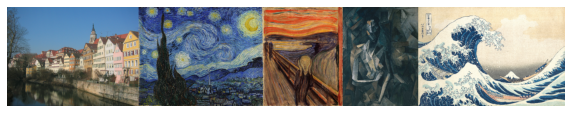

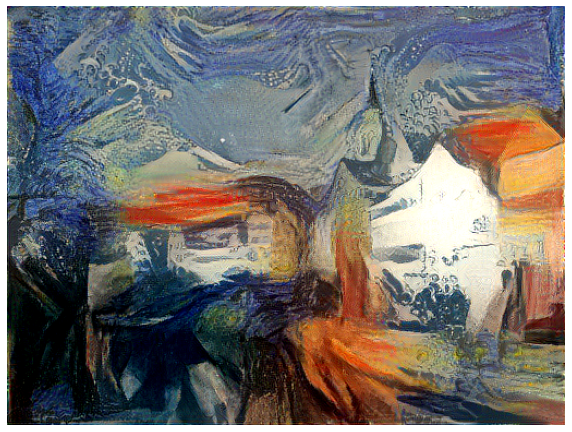

In [ ]:
# Set content and style targets
content_layers = [vgg16_model.features[20]]
style_layers = [
    vgg16_model.features[1],
    vgg16_model.features[6],
    vgg16_model.features[11],
    vgg16_model.features[18],
    vgg16_model.features[25],
]

# Set content and style weights
content_weight = 0.05
style_weight = 1000.0

# Optionally set the style scale
style_scale = 1.0

# Setup input images & scale to [0, 255]
image_size = 512
content_image = resize_image(content_image_full, image_size).to(device) * image_scale

style_image_list = [style_image_full, style_2, style_3, style_4]
style_image_list = resize_image(style_image_list, image_size, style_scale)
style_images = [image.to(device) * image_scale for image in style_image_list]

# Optionally specify blend weights for each style image used
style_blend_weights = [1, 1, 1, 0.5]  # Set equal to None for no blend weights

# Initialize from random noise
init_image = None
# Uncomment to initialize from random noise
#init_image = torch.randn_like(content_image) * 0.001

# The number of rendering steps to use
num_steps = 512

# Perform neural style transfer
output_4_styles = vis_style_transfer_vgg(
    model=vgg16_model,
    content_image=content_image,
    style_image=style_images,
    content_layers=content_layers,
    style_layers=style_layers,
    content_weight=content_weight,
    style_weight=style_weight,
    init_image=init_image,
    num_steps=num_steps,
    style_blend_weights=style_blend_weights,
    transforms=TransformVGG(),
).clamp(0, image_scale)  # Clamp output to avoid artifacts

# Show inputs & results
show_input_images(content_image, style_images, figsize=(10, 10), scale=export_scale)
opt.images.show(output_4_styles, figsize=(10, 10), scale=export_scale)